In [1]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_images_dir = '/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train'
image_size= 224

train_datagen = ImageDataGenerator(
    rescale=1./255,  
    validation_split=0.2, 
    # zoom_range=0.15,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.15
)


# Create the training generator for training data
train_generator = train_datagen.flow_from_directory(
    train_images_dir,  # Path to the training images
    target_size=(image_size, image_size),  # Resize images to target size (set image_size beforehand)
    batch_size=32,  # Number of images to process in each batch
    class_mode='categorical',  # For multi-class classification
    subset='training',  # Set subset to 'training' for training data
    shuffle=True,  # Shuffle data after each epoch
)

# Create the validation generator
validation_generator = train_datagen.flow_from_directory(
    train_images_dir, 
    target_size=(image_size, image_size),  
    batch_size=32,  
    class_mode='categorical',  
    subset='validation', 
    shuffle=False, 

)

Found 6598 images belonging to 196 classes.
Found 1546 images belonging to 196 classes.


In [2]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models, optimizers, callbacks

def identity_block(x, filters):
    f1, f2, f3 = filters
    
    shortcut = x
    x = Conv2D(f1, (1, 1), strides=(1, 1))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f2, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f3, (1, 1))(x)
    x = BatchNormalization()(x)

    # Add shortcut and main path
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

def convolutional_block(x, filters, strides=(2, 2)):
    f1, f2, f3 = filters

    # Shortcut Path
    shortcut = Conv2D(f3, (1, 1), strides=strides)(x)
    shortcut = BatchNormalization()(shortcut)

    # Main Path
    x = Conv2D(f1, (1, 1), strides=strides)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f2, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f3, (1, 1))(x)
    x = BatchNormalization()(x)

    # Add shortcut and main path
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

def ResNet50(input_shape=(224, 224, 3), classes=196):
    inputs = Input(input_shape)

    # Initial Convolutional Layer
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Residual Blocks
    x = convolutional_block(x, [64, 64, 256], strides=(1, 1))
    x = identity_block(x, [64, 64, 256])
    x = identity_block(x, [64, 64, 256])

    x = convolutional_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])

    x = convolutional_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])

    x = convolutional_block(x, [512, 512, 2048])
    x = identity_block(x, [512, 512, 2048])
    x = identity_block(x, [512, 512, 2048])

    # Final Layers
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(196, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


model = ResNet50(input_shape=(224, 224, 3), classes=196)
model.summary()
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Model
model = ResNet50(input_shape=(224, 224, 3), classes=196)
model.summary()

# Optimizer: SGD
optimizer = SGD(learning_rate=0.01, momentum=0.9)  # SGD with momentum
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',  # Use for one-hot encoded labels
    metrics=['accuracy']
)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',     # Monitor validation loss
    factor=0.002,             # Reduce learning rate by a factor of 0.5
    patience=3,             # Number of epochs with no improvement
    min_lr=1e-6,            # Minimum learning rate
    verbose=1               # Print update messages
)


# Train the model with callbacks
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=validation_generator.samples // 32,
    #callbacks=[reduce_lr, early_stopping],  # Include callbacks
    verbose=1  # Show detailed progress during training
)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     16,640 │ activation_2[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │     16,640 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 56, 56,    │          0 │ add[0][0]       

 Total params: 23,989,316 (91.51 MB)

 Trainable params: 23,936,196 (91.31 MB)

 Non-trainable params: 53,120 (207.50 KB)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 112, 112,  │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_53[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_49       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ activation_49[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 56, 56,    │      4,160 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_55[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_50       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 56, 56,    │     36,928 │ activation_50[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_56[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_51       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 56, 56,    │     16,640 │ activation_51[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 56, 56,    │     16,640 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_57[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_54[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_52       │ (None, 56, 56,    │          0 │ add_16[0][0]    

 Total params: 23,989,316 (91.51 MB)

 Trainable params: 23,936,196 (91.31 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734565110.070524      81 service.cc:145] XLA service 0x7dc7a0003fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734565110.070579      81 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734565110.070583      81 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1734565129.606607      81 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


165/206 ━━━━━━━━━━━━━━━━━━━━ 16s 405ms/step - accuracy: 0.0046 - loss: 6.5124

I0000 00:00:1734565196.273215      82 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_48', 24 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 56 bytes spill stores, 56 bytes spill loads



206/206 ━━━━━━━━━━━━━━━━━━━━ 135s 475ms/step - accuracy: 0.0047 - loss: 6.4114 - val_accuracy: 0.0085 - val_loss: 6.7159
Epoch 2/50
  1/206 ━━━━━━━━━━━━━━━━━━━━ 1:05 318ms/step - accuracy: 0.0000e+00 - loss: 5.4438

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.0000e+00 - loss: 5.4438 - val_accuracy: 0.0000e+00 - val_loss: 6.4209
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 73s 348ms/step - accuracy: 0.0063 - loss: 5.3576 - val_accuracy: 0.0111 - val_loss: 5.2662
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step - accuracy: 0.0625 - loss: 5.2536 - val_accuracy: 0.0000e+00 - val_loss: 5.2121
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 72s 344ms/step - accuracy: 0.0133 - loss: 5.2072 - val_accuracy: 0.0130 - val_loss: 5.2272
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step - accuracy: 0.0000e+00 - loss: 5.1757 - val_accuracy: 0.0000e+00 - val_loss: 5.2729
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 72s 343ms/step - accuracy: 0.0198 - loss: 5.1232 - val_accuracy: 0.0111 - val_loss: 7.6840
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step - accuracy: 0.0312 - loss: 5.0306 - val_accuracy: 0.0000e+00 - val_loss: 5.6962
Epoch 9/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 73s 347ms/step - accuracy: 0.0194 -

In [3]:
test_dir = '/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=32,
    class_mode='categorical', 
    shuffle=False  
)

Found 8041 images belonging to 196 classes.


In [4]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // 32)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')


251/251 ━━━━━━━━━━━━━━━━━━━━ 70s 280ms/step - accuracy: 0.0733 - loss: 8.1172
Test Loss: 8.344849586486816
Test Accuracy: 0.06436753273010254


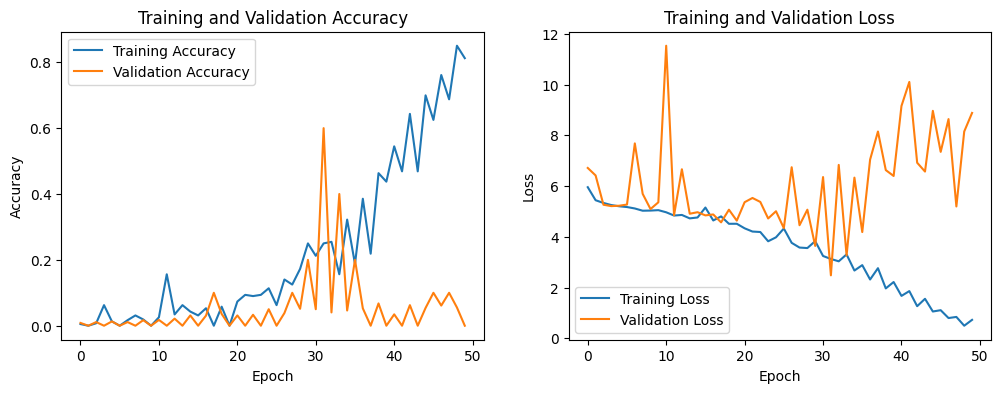

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

# Accuracy Curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 188ms/step


<Figure size 800x600 with 0 Axes>

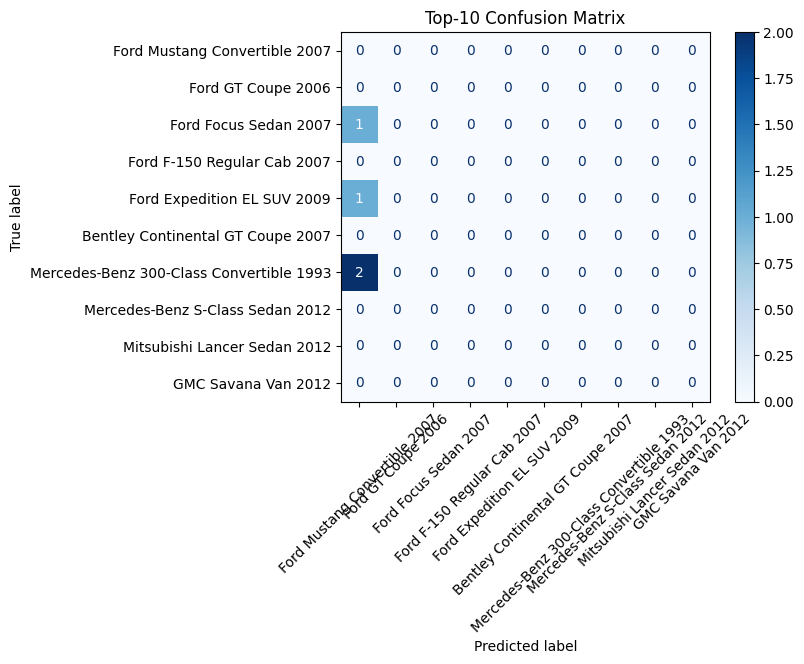

In [6]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get Ground Truth Labels and Predictions
Y_true = validation_generator.classes  # Ground truth
Y_pred = model.predict(validation_generator)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Compute Confusion Matrix
cm = confusion_matrix(Y_true, Y_pred_classes)

# Sum of misclassifications per class
misclassifications = np.sum(cm, axis=1) - np.diag(cm)

# Select Top-K Classes with Most Misclassifications
K = 10
top_k_classes = np.argsort(misclassifications)[-K:]

# Create Reduced Confusion Matrix
cm_reduced = cm[np.ix_(top_k_classes, top_k_classes)]
class_labels = np.array(list(validation_generator.class_indices.keys()))[top_k_classes]

# Display Reduced Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_reduced, display_labels=class_labels)

plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title(f"Top-{K} Confusion Matrix")
plt.show()


49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step


<Figure size 800x600 with 0 Axes>

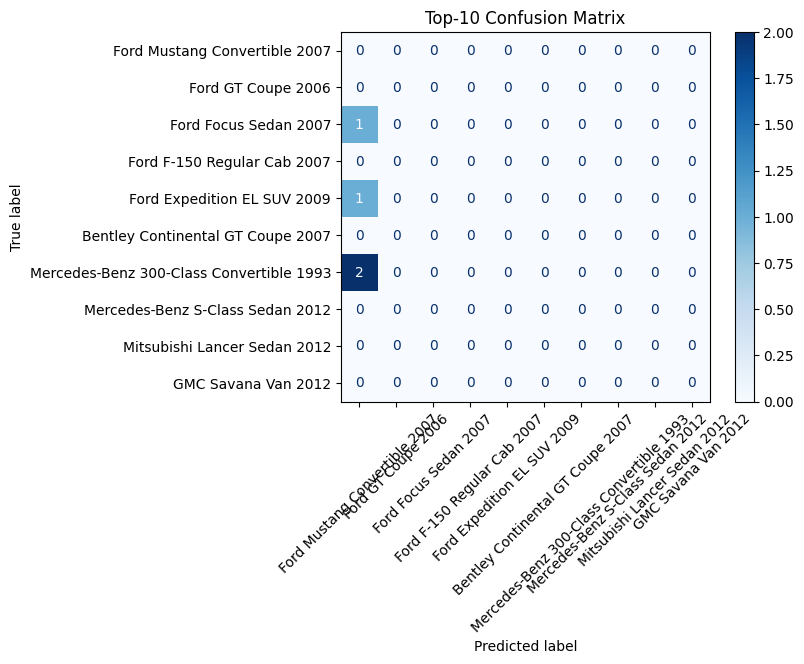

In [7]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get Ground Truth Labels and Predictions
Y_true = validation_generator.classes  # Ground truth
Y_pred = model.predict(validation_generator)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Compute Confusion Matrix
cm = confusion_matrix(Y_true, Y_pred_classes)

# Sum of misclassifications per class
misclassifications = np.sum(cm, axis=1) - np.diag(cm)

# Select Top-K Classes with Most Misclassifications
K = 10
top_k_classes = np.argsort(misclassifications)[-K:]

# Create Reduced Confusion Matrix
cm_reduced = cm[np.ix_(top_k_classes, top_k_classes)]
class_labels = np.array(list(validation_generator.class_indices.keys()))[top_k_classes]

# Display Reduced Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_reduced, display_labels=class_labels)

plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title(f"Top-{K} Confusion Matrix")
plt.show()

In [8]:
from sklearn.metrics import classification_report

# Generate Classification Report
print("Classification Report:\n")
report = classification_report(Y_true, Y_pred_classes, target_names=validation_generator.class_indices.keys())
print(report)

Classification Report:

                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000       0.00      0.00      0.00         9
                             Acura Integra Type R 2001       0.11      0.33      0.16         9
                                   Acura RL Sedan 2012       0.00      0.00      0.00         6
                                   Acura TL Sedan 2012       0.00      0.00      0.00         8
                                  Acura TL Type-S 2008       0.00      0.00      0.00         8
                                  Acura TSX Sedan 2012       0.00      0.00      0.00         8
                              Acura ZDX Hatchback 2012       0.09      0.14      0.11         7
              Aston Martin V8 Vantage Convertible 2012       0.00      0.00      0.00         9
                    Aston Martin V8 Vantage Coupe 2012       0.00      0.00      0.00         8
               

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


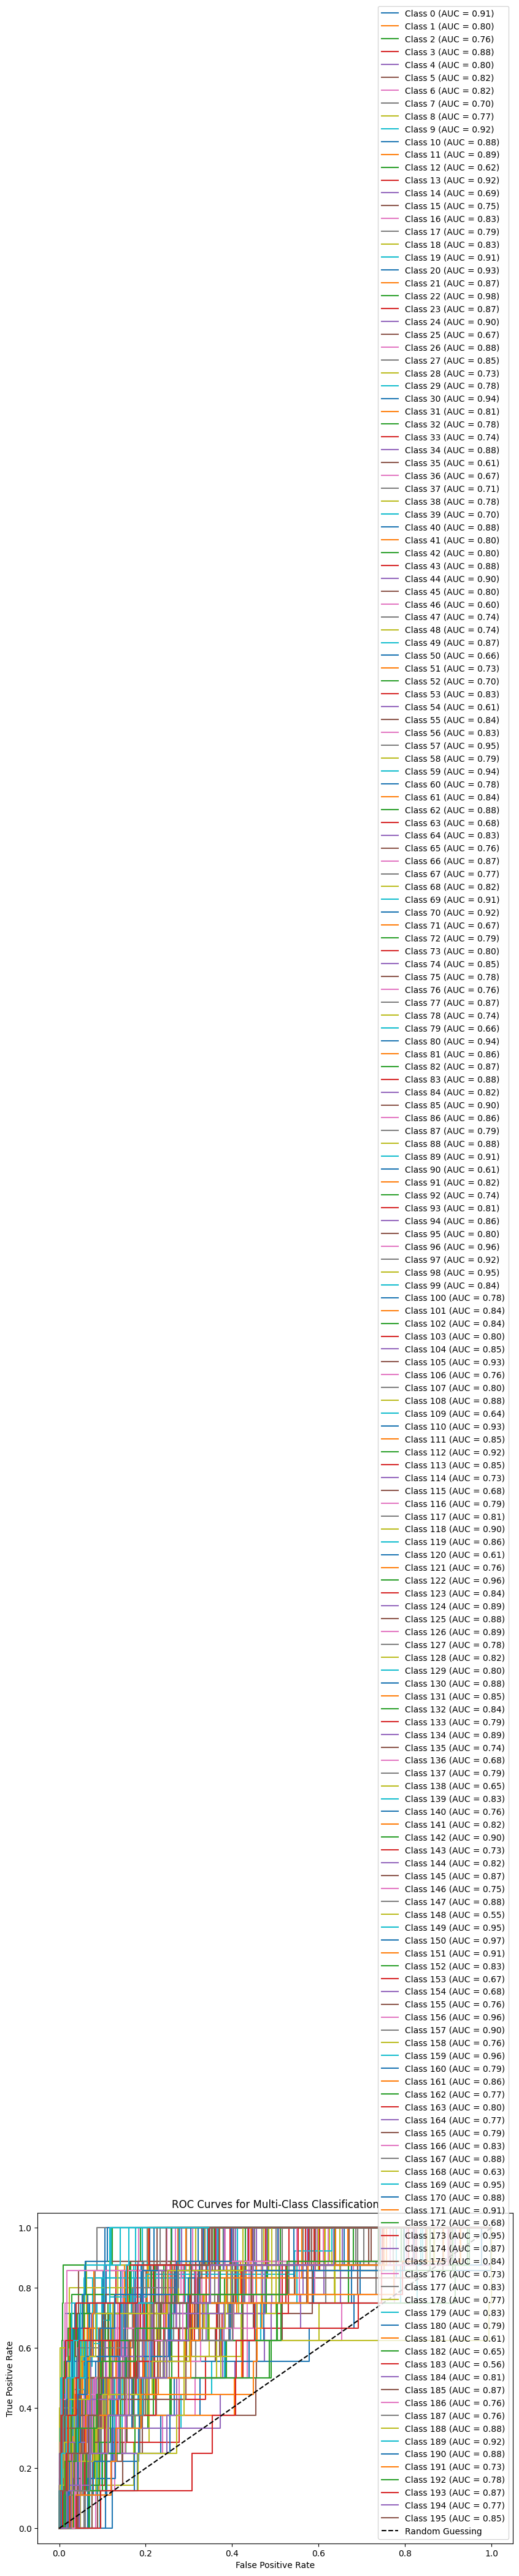

In [9]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class ROC
n_classes = len(validation_generator.class_indices)
Y_true_bin = label_binarize(Y_true, classes=[i for i in range(n_classes)])

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_true_bin[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Multi-Class Classification")
plt.legend(loc="lower right")
plt.show()
